# View Part of an NAIP Scene

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrahnis/nb-vegetation/blob/main/Veggie-View.ipynb)

In [1]:
# if the notebook is running in colab we'll get the data from github
HOST_IS_COLAB = 'google.colab' in str(get_ipython())

if HOST_IS_COLAB:
    # if using the regular Colab runtime install rasterio and others packages
    !pip install rasterio --quiet --exists-action i
    path = 'https://github.com/mrahnis/nb-vegetation/blob/main'
    params = '?raw=true'
else:
    path = '.'
    params = ''

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import colormaps
from skimage.exposure import histogram
import rasterio

In [3]:
"""Load RGB+NIR TIFF data"""
# image_file = './data/pa_greatmarsh_2022_naip.tif'
image_file = '{}/data/pa_greatmarsh_2022_naip.tif{}'.format(path, params)
src = rasterio.open(image_file)

# read band data
rgb = src.read()
# switch from band-first raster to band-last image
img = np.moveaxis(src.read(), 0, 2)

## RGB Color and Near-IR

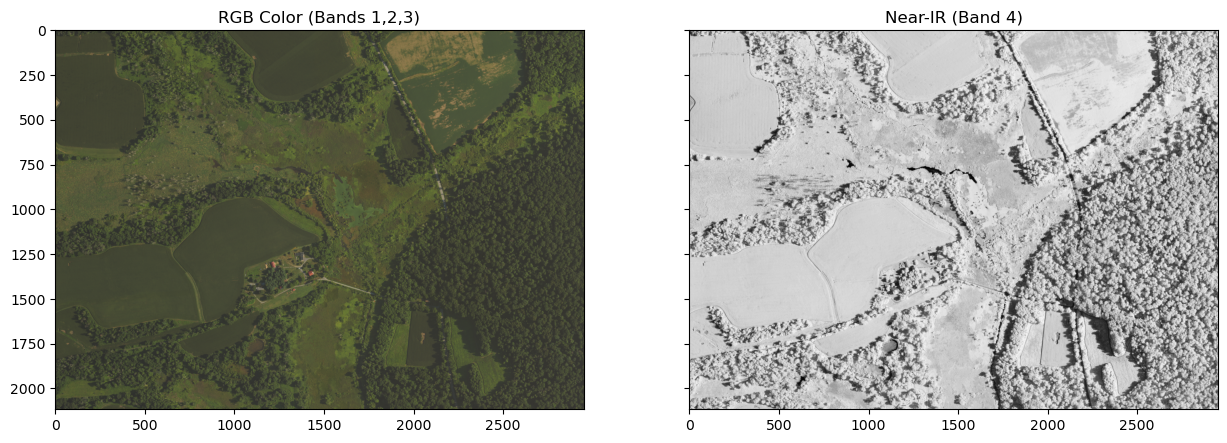

In [4]:
"""Plot the imagery"""
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 8))

ax[0].imshow(img[:,:,:3])
ax[0].set_title("RGB Color (Bands 1,2,3)")

ax[1].imshow(img[:,:,3], cmap='gray')
ax[1].set_title("Near-IR (Band 4)")

plt.show()

### Observations

The RGB color image clearly shows that several vegetation types exist in the valley-bottom. We can also distinguish forest, fields and roads. The Near-IR data from band 4 shows some variability in brightness of the vegetation, and darker shadows that correspond to shadows apparent in the RGB color image. Near-IR additionally shows some dark open-water areas that aren't readily visible in the RGB image. 

   ## NDVI and NWDI

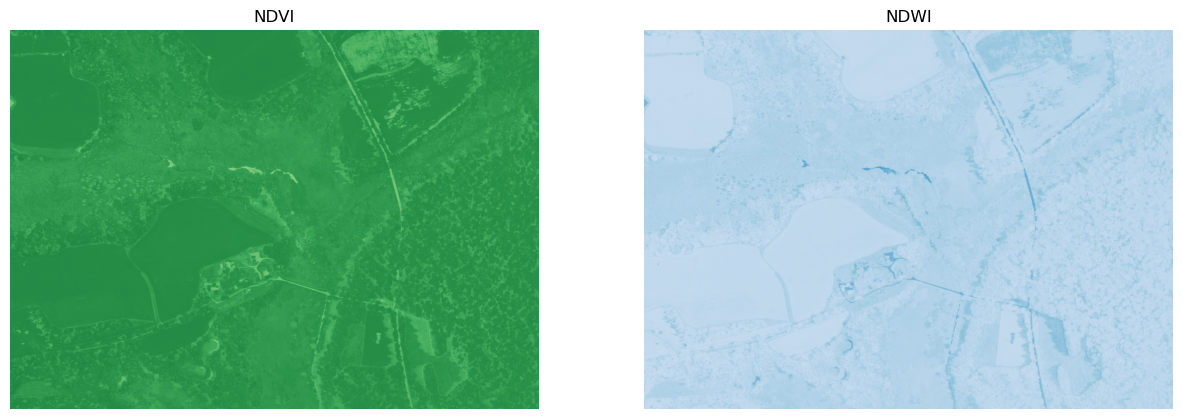

In [5]:
norm = img/255
ndvi = (norm[:,:,3] - norm[:,:,0])/(norm[:,:,3] + norm[:,:,0])
ndwi = (norm[:,:,1] - norm[:,:,3])/(norm[:,:,1] + norm[:,:,3])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 12), sharex=True, sharey=True)

ax0.imshow(ndvi, cmap='Greens', vmin=-1.0, vmax=1.0)
ax0.set_title("NDVI")
ax0.axis('off')

ax1.imshow(ndwi, cmap='Blues', vmin=-1.0, vmax=1.0)
ax1.set_title("NDWI")
ax1.axis('off')

plt.show()

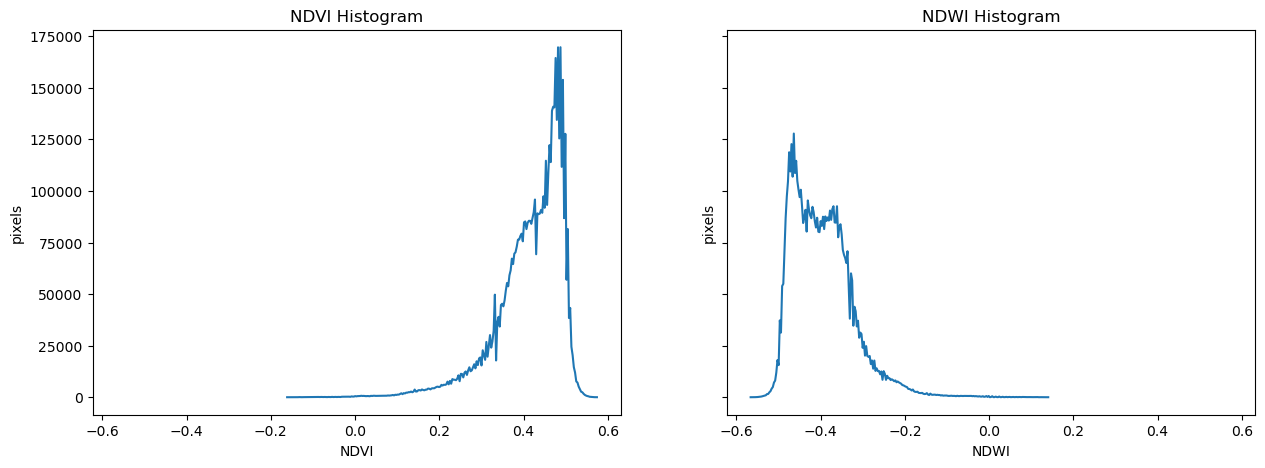

In [6]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 5), sharey=True, sharex=True)

V_hist, V_centers = histogram(ndvi, nbins=256)
ax0.plot(V_centers, V_hist)
ax0.set_title("NDVI Histogram")
ax0.set_xlabel('NDVI')
ax0.set_ylabel('pixels')

W_hist, W_centers = histogram(ndwi, nbins=256)
ax1.plot(W_centers, W_hist)
ax1.set_title("NDWI Histogram")
ax1.set_xlabel('NDWI')
ax1.set_ylabel('pixels')

plt.show()

### Observations

From NDVI and NDWI we can visually distinguish between fields, forest, roads and wetland. Little separation exists, however, between these potential classes, and we completely lose the distinct patchiness of the wetland types. Histograms of NDVI and NDWI histograms further show broad peaks with a shoulder on one side.

## L\*a\*b\* Colorspace

Our Great Marsh wetland scene is dominated by green vegetation during growing season. Much of the variability is in qualities of saturation and luminosity of these greens. We can experiment with colorspaces other than RGB to see this.

a*: -23.007173550230327 37.3243772124851
b*: -29.557203887911232 53.61314610231875


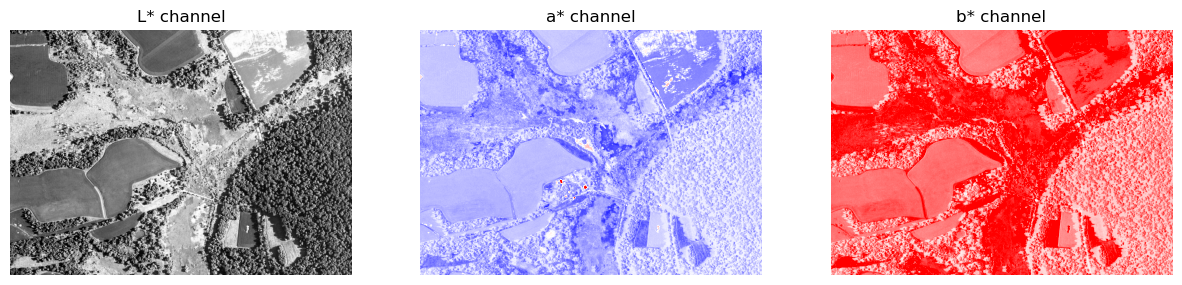

In [7]:
from skimage.color import rgb2lab
from skimage.exposure import histogram, adjust_gamma, adjust_sigmoid, rescale_intensity, equalize_hist

lab = rgb2lab(img[:,:,:3])

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 8), sharex=True, sharey=True)

L_star = lab[:,:,0]
# ax2.imshow(adjust_gamma(L_star, gamma=1.6), cmap='gray', norm='linear')
print('L*:', L_star.min(), L_star.max())
ax0.imshow(equalize_hist(L_star), cmap='gray')
ax0.set_title("L* channel")
ax0.axis('off')

a_star = lab[:,:,1]
print('a*:', a_star.min(), a_star.max())
ax1.imshow(a_star, cmap='bwr', vmin=-20, vmax=20)
ax1.set_title("a* channel")
ax1.axis('off')

b_star = lab[:,:,2]
print('b*:', b_star.min(), b_star.max())
ax2.imshow(b_star, cmap='bwr', vmin=-20, vmax=20)
ax2.set_title("b* channel")
ax2.axis('off')

plt.show()

In the figure above the RGB channels have been converted to L\*a\*b\* colorspace. L* (Luma) is displayed in grayscale and the a* and b* channels are displayed with a blue-white-red color ramp (blue is negative; red is positive).

```
L* = Luma 0-100
+a* = red
-a* = green
+b* = yellow
-b* = blue
```
Greens (-a\*) dominate the a\* channel, except for the red roofs and some areas of bare soil, whereas yellows (+b\*) dominate the b\* channel.

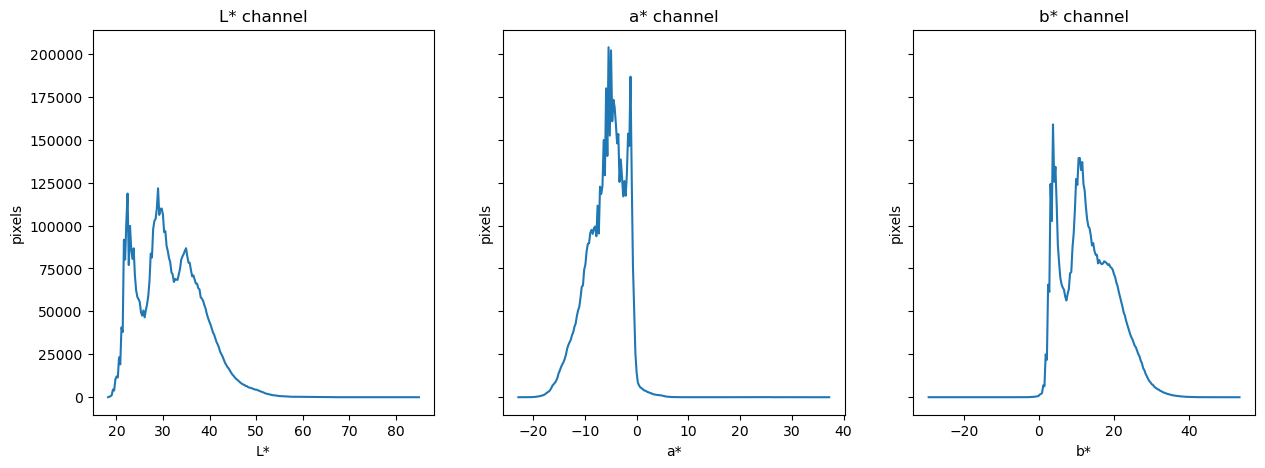

In [8]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)

L_hist, L_centers = histogram(L_star, nbins=256)
ax0.plot(L_centers, L_hist)
ax0.set_title("L* channel")
ax0.set_xlabel('L*')
ax0.set_ylabel('pixels')

a_hist, a_centers = histogram(a_star, nbins=256)
ax1.plot(a_centers, a_hist)
ax1.set_title("a* channel")
ax1.set_xlabel('a*')
ax1.set_ylabel('pixels')

b_hist, b_centers = histogram(b_star, nbins=256)
ax2.plot(b_centers, b_hist)
ax2.set_title("b* channel")
ax2.set_xlabel('b*')
ax2.set_ylabel('pixels')

plt.show()

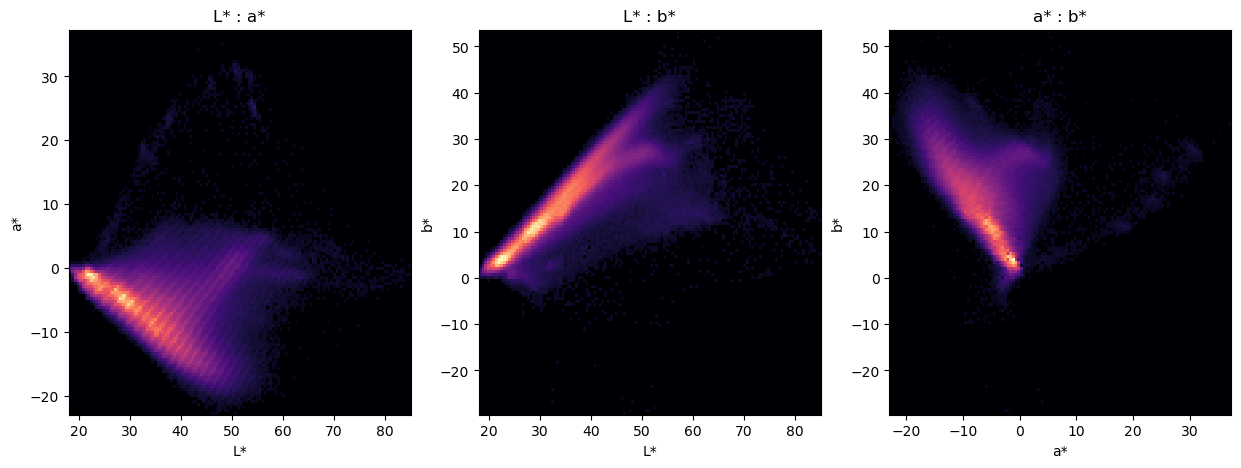

In [9]:
gamma = 0.25

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))

ax0.hist2d(L_star.ravel(), a_star.ravel(), bins=128, norm=colors.PowerNorm(gamma), cmap='magma')
#ax0.hist2d(L_star.ravel(), a_star.ravel(), bins=128, norm=colors.LogNorm(), cmap='magma')
ax0.set_title("L* : a*")
ax0.set_xlabel('L*')
ax0.set_ylabel('a*')

ax1.hist2d(L_star.ravel(), b_star.ravel(), bins=128, norm=colors.PowerNorm(gamma), cmap='magma')
#ax1.hist2d(L_star.ravel(), b_star.ravel(), bins=128, norm=colors.LogNorm(), cmap='magma')
ax1.set_title("L* : b*")
ax1.set_xlabel('L*')
ax1.set_ylabel('b*')

ax2.hist2d(a_star.ravel(), b_star.ravel(), bins=128, norm=colors.PowerNorm(gamma), cmap='magma')
#ax2.hist2d(a_star.ravel(), b_star.ravel(), bins=128, norm=colors.LogNorm(), cmap='magma')
ax2.set_title("a* : b*")
ax2.set_xlabel('a*')
ax2.set_ylabel('b*')

plt.show()

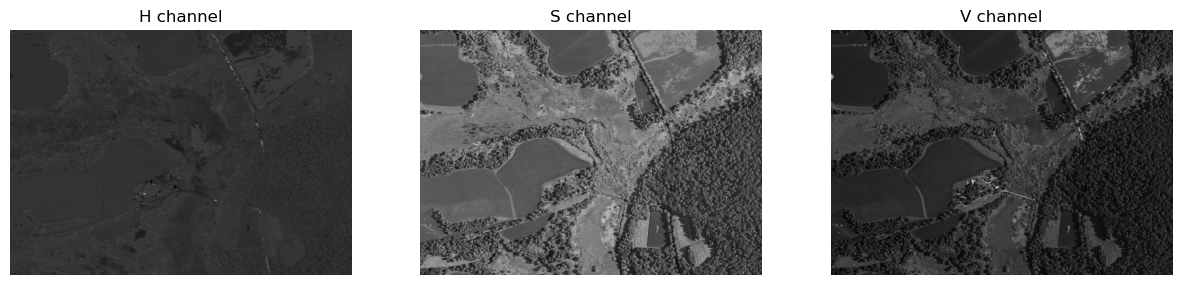

In [10]:
# HSV colorspace
from skimage.color import rgb2hsv

hsv = rgb2hsv(img[:,:,:3])

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 8), sharex=True, sharey=True)

H = hsv[:,:,0]
# ax2.imshow(adjust_gamma(L_star, gamma=1.6), cmap='gray', norm='linear')
ax0.imshow(H, cmap='gray')
ax0.set_title("H channel")
ax0.axis('off')

S = hsv[:,:,1]
ax1.imshow(S, cmap='gray')
ax1.set_title("S channel")
ax1.axis('off')

V = hsv[:,:,2]
ax2.imshow(V, cmap='gray')
ax2.set_title("V channel")
ax2.axis('off')

plt.show()

Kim, DW., Jeong, S.J., Lee, W.S. et al. Growth monitoring of field-grown onion and garlic by CIE L*a*b* color space and region-based crop segmentation of UAV RGB images. Precision Agric 24, 1982–2001 (2023).
https://doi.org/10.1007/s11119-023-10026-8

Wahono, Wahono & Indradewa, Didik & Sunarminto, Bambang & Haryono, Eko & Prajitno, Djoko. (2019). CIE L*a*b* Color Space Based Vegetation Indices Derived from Unmanned Aerial Vehicle Captured Images for Chlorophyll and Nitrogen Content Estimation of Tea (Camellia sinensis L. Kuntze) Leaves. Ilmu Pertanian (Agricultural Science). 4. 46.
http://dx.doi.org/10.22146/ipas.40693